In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import LSTMModel, MLPModel, LinearRegressionModel
from dataset import Dataset

# Load Data

In [76]:
building_dataset_path = "/Users/adrian/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/TFG/Code/data/consumption/MA_baseline_metadata_and_annual_results.parquet"
building_dataset = pd.read_parquet(building_dataset_path)

In [77]:
weather_dataset_path = "/Users/adrian/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/TFG/Code/data/consumption/G2500170_2018.csv"
weather_dataset = pd.read_csv(weather_dataset_path)

weather_dataset = weather_dataset.drop(columns=["Global Horizontal Radiation [W/m2]", "Diffuse Horizontal Radiation [W/m2]"])
weather_dataset['date'] = pd.to_datetime(weather_dataset['date_time'])
weather_dataset = weather_dataset.set_index('date')
weather_dataset = weather_dataset.drop(columns=["date_time"])
weather_dataset = weather_dataset.resample('15T').ffill()

# Normalize weather data
weather_dataset = (weather_dataset - weather_dataset.mean()) / weather_dataset.std()

/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_41705/2507247055.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_dataset = weather_dataset.resample('15T').ffill()


In [78]:
def get_idx_from_path(path: str) -> int:
    idx = path.split("/")[-1].split("_")[0]
    # Remove .parquet from the end
    idx = idx[:-10]
    return int(idx)

paths = [
    "/Users/adrian/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/TFG/Code/data/consumption/10-0.parquet",
    "/Users/adrian/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/TFG/Code/data/consumption/1000-0.parquet",
    # "/Users/adrian/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/TFG/Code/data/consumption/10004-0.parquet",
    # "/Users/adrian/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/TFG/Code/data/consumption/100001-0.parquet",
    # "/Users/adrian/Library/Mobile Documents/com~apple~CloudDocs/Documents/ICAI/TFG/Code/data/consumption/100061-0.parquet",
]

timeseries_dict = {}
idxs = {}

i = 1
for path in paths:
    building_timeseries = pd.read_parquet(path)
    building_timeseries = building_timeseries.iloc[3:]

    # Parse dates
    building_timeseries['date'] = pd.to_datetime(building_timeseries['timestamp'])
    building_timeseries = building_timeseries.set_index('date')
    building_timeseries = building_timeseries.drop(columns=["timestamp"])

    timeseries_dict[i] = building_timeseries
    idxs[i] = get_idx_from_path(path)
    i += 1

# Transform data

In [79]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [80]:
for num in timeseries_dict:
    col = get_cols(building_dataset, idxs[num])
    # Turn into a numpy array of shape (n, 1)
    timeseries_dict[num] = timeseries_dict[num][col].values.reshape(-1, 1)

In [81]:
# Turn weather data into list of numpy arrays
weather_data = []
for i in range(len(timeseries_dict[1])):
    weather_data.append(weather_dataset.iloc[i].values)
weather_data = np.array(weather_data)

In [82]:
building_dataset = building_dataset[building_dataset["in.county"] == "G2500170"]

In [83]:
features_dict = {}

for num in idxs:
    try:
        building = building_dataset[building_dataset.index == idxs[num]]
        # Only keep columns that start by 'in.'
        for col in building.columns:
            if not col.startswith("in."):
                building = building.drop(columns=[col])

        features_dict[num] = building
    except:
        raise Exception(f"Building with id {idxs[num]} not found in the dataset")
    
# Turn all columns of each feature in feature dict into float64
for num in features_dict:
    for col in features_dict[num].columns:
        try:
            features_dict[num][col] = features_dict[num][col].astype("float64")
        except:
            features_dict[num] = features_dict[num].drop(columns=[col])

In [84]:
# Turn each feature dataframe into a list
for num in features_dict:
    features_dict[num] = features_dict[num].values.reshape(-1, 1)

In [85]:
# Normalize each feature
for num in features_dict:
    features_dict[num] = (features_dict[num] - features_dict[num].mean()) / features_dict[num].std()

In [86]:
def create_single_sequence(time_series, window_size):
    X, y = [], []
    for i in range(len(time_series) - window_size):
        X.append(time_series[i:i+window_size])
        y.append(time_series[i+window_size])
    return np.array(X), np.array(y)

In [87]:
def create_sequences(time_series, weather, exogenous, window_size):
    sequences = []
    labels = []
    for i in range(len(time_series) - window_size):
        # Combine time series + weather data
        ts_weather_seq = np.hstack([time_series[i:i + window_size], weather[i:i + window_size]])  # Shape: (50, 6)
        labels.append(time_series[i + window_size])
        
        exogenous = exogenous.reshape(1, -1)
        exogenous_seq = np.repeat(exogenous, window_size, axis=0)
        
        # Combine everything (time series + weather + exogenous)
        combined_seq = np.hstack([ts_weather_seq, exogenous_seq])  # Shape: (50, 31)
        
        sequences.append(combined_seq)
    
    return np.array(sequences), np.array(labels)


In [88]:
num_previous_steps = 5

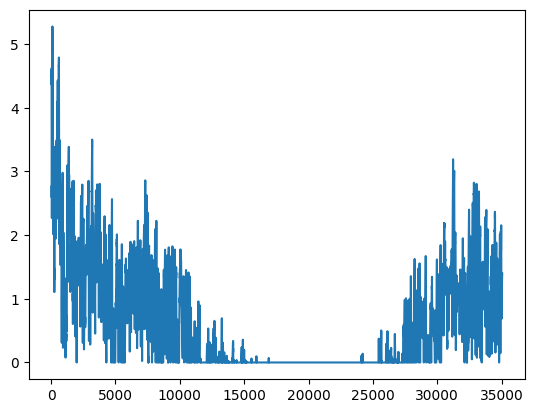

In [89]:
# plot timeseries
plt.plot(timeseries_dict[1])
plt.show()

In [90]:
sequence_dict = {}
label_dict = {}

for num in timeseries_dict:
    sequence_dict[num], label_dict[num] = create_sequences(timeseries_dict[num], weather_data, features_dict[num], num_previous_steps)

In [91]:
train_data = sequence_dict[1][:int(0.8 * len(sequence_dict[1]))]
test_data = sequence_dict[1][int(0.8 * len(sequence_dict[1])):]

train_labels = label_dict[1][:int(0.8 * len(label_dict[1]))]
test_labels = label_dict[1][int(0.8 * len(label_dict[1])):]


In [92]:
time_series_seq, time_series_seq_labels = create_single_sequence(timeseries_dict[1], num_previous_steps)

In [93]:
train_data_seq = time_series_seq[:int(0.8 * len(time_series_seq))]
test_data_seq = time_series_seq[int(0.8 * len(time_series_seq)):]

train_labels_seq = time_series_seq_labels[:int(0.8 * len(time_series_seq))]
test_labels_seq = time_series_seq_labels[int(0.8 * len(time_series_seq)):]

# Define LSTM model

In [94]:
# Hyperparameters
input_size = train_data.shape[2]  # Number of features (time series + exogenous variables)
hidden_size = 50               # Number of LSTM units
num_layers = 2                 # Number of LSTM layers
output_size = 1                # Predicting one value (next time step)
learning_rate = 0.00001
num_epochs = 10
batch_size = 64

In [95]:
lstm_model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

In [96]:
critetion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
lstm_model.to(device)

train_data, train_labels = torch.from_numpy(train_data).float().to(device), torch.from_numpy(train_labels).float().to(device)
test_data, test_labels = torch.from_numpy(test_data).float().to(device), torch.from_numpy(test_labels).float().to(device)

In [98]:
train_dataset = Dataset(train_data, train_labels)
test_dataset = Dataset(test_data, test_labels)

In [99]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [100]:
model_name = "lstm_12"
writer = SummaryWriter(log_dir=f"runs/lstm/{model_name}")

## Train LSTM model

In [101]:
# Training loop
lstm_model.train()
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = lstm_model(inputs)
        loss = critetion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch}, step {i}, loss: {loss.item()}")
        
        writer.add_scalar('training loss', loss.item(), epoch * len(train_loader) + i)

Epoch 0, step 0, loss: 0.4012969434261322
Epoch 0, step 100, loss: 0.7577839493751526
Epoch 0, step 200, loss: 0.6587398648262024
Epoch 0, step 300, loss: 1.236533761024475
Epoch 0, step 400, loss: 0.5408700704574585
Epoch 1, step 0, loss: 1.0971964597702026
Epoch 1, step 100, loss: 0.9484731554985046
Epoch 1, step 200, loss: 0.5282410979270935
Epoch 1, step 300, loss: 0.44892382621765137
Epoch 1, step 400, loss: 0.614561140537262
Epoch 2, step 0, loss: 0.871871829032898
Epoch 2, step 100, loss: 0.46827420592308044
Epoch 2, step 200, loss: 0.29495668411254883
Epoch 2, step 300, loss: 0.11288538575172424
Epoch 2, step 400, loss: 0.2506687641143799
Epoch 3, step 0, loss: 0.28943580389022827
Epoch 3, step 100, loss: 0.09509081393480301
Epoch 3, step 200, loss: 0.07691949605941772
Epoch 3, step 300, loss: 0.29508572816848755
Epoch 3, step 400, loss: 0.0551418662071228
Epoch 4, step 0, loss: 0.039778124541044235
Epoch 4, step 100, loss: 0.043167274445295334
Epoch 4, step 200, loss: 0.090863

In [102]:
test_loss = []

for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = lstm_model(inputs)
    loss = critetion(outputs, labels)
    test_loss.append(loss.item())

print(f"Test loss: {np.mean(test_loss)}")

Test loss: 0.03003085194663568


In [103]:
print(np.mean(test_labels.cpu().numpy()))

1.0454648


## Plot LSTM results

In [104]:
# Get predictions
predictions = []

lstm_model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = lstm_model(inputs)
        predictions.append(outputs.cpu().numpy())

    

In [ ]:
# Get predictions by using the predicted values as input
lstm_model.eval()
predictions_2 = []

with torch.no_grad():
    initial_input = test_data[0].reshape(1, 5, 31)
    for i in range(len(test_data)):
        print(f"Step {i}/{len(test_data)}           ", end="\r")
        inputs = initial_input.float().to(device)
        outputs = lstm_model(inputs)
        predictions_2.append(outputs.cpu().numpy())
        print(outputs.shape)
        initial_input = torch.cat((initial_input[0][1:], outputs)).reshape(1, 5, 31)
        print(initial_input)
    

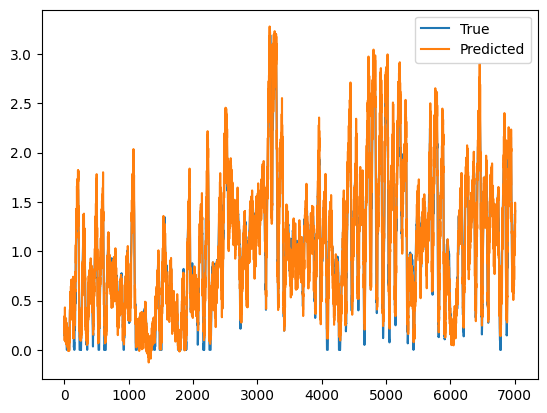

In [105]:
# Plot predictions
plt.plot(test_labels.cpu().numpy(), label='True')
plt.plot(np.concatenate(predictions), label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Plot predictions
plt.plot(test_labels.cpu().numpy(), label='True')
plt.plot(np.concatenate(predictions_2), label='Predicted')
plt.legend()
plt.show()

# Define MLP model

In [ ]:
train_data_reshape = train_data.reshape(train_data.shape[0], -1)
test_data_reshape = test_data.reshape(test_data.shape[0], -1)

In [ ]:
# Hyperparameters
input_size = train_data_reshape.shape[1]  # Number of features (time series + exogenous variables)
hidden_size_1 = 500
hidden_size_2 = 100
output_size = 1                # Predicting one value (next time step)
learning_rate = 0.0001
num_epochs = 100
batch_size = 64

In [ ]:
mlp_model = MLPModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
mlp_model.to(device)

In [ ]:
train_dataset_reshape = Dataset(train_data_reshape, train_labels)
test_dataset_reshape = Dataset(test_data_reshape, test_labels)

In [ ]:
train_dataloader_reshape = torch.utils.data.DataLoader(dataset=train_dataset_reshape, batch_size=batch_size, shuffle=True)
test_dataloader_reshape = torch.utils.data.DataLoader(dataset=test_dataset_reshape, batch_size=batch_size, shuffle=False)

In [ ]:
model_name = "mlp_2"
writer = SummaryWriter(log_dir=f"runs/mlp/{model_name}")

## Train MLP model

In [ ]:
# Train loop
mlp_model.train()
for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader_reshape):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = mlp_model(inputs)
        loss = critetion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch}, step {i}, loss: {loss.item()}")
        
        writer.add_scalar('training loss', loss.item(), epoch * len(train_dataloader_reshape) + i)

In [ ]:
test_loss = []

for i, data in enumerate(test_dataloader_reshape):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = mlp_model(inputs)
    loss = critetion(outputs, labels)
    test_loss.append(loss.item())

print(f"Test loss: {np.mean(test_loss)}")

In [ ]:
print(np.mean(test_labels.cpu().numpy()))

# Define LinearRegression model

In [106]:
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

In [107]:
print(timeseries_dict[1][0:7])

[[4.49746864]
 [4.49776171]
 [4.49805479]
 [4.50391621]
 [4.50860534]
 [4.49629636]
 [4.4857458 ]]


In [73]:
print(weather_data[0:7])

[[-2.55861522 -1.01975894  1.71311317  1.05340563 -0.61346046]
 [-2.55861522 -1.01975894  1.71311317  1.05340563 -0.61346046]
 [-2.55861522 -1.01975894  1.71311317  1.05340563 -0.61346046]
 [-2.55861522 -1.01975894  1.71311317  1.05340563 -0.61346046]
 [-2.61402677 -1.02796486  1.49743178  0.94827724 -0.61346046]
 [-2.61402677 -1.02796486  1.49743178  0.94827724 -0.61346046]
 [-2.61402677 -1.02796486  1.49743178  0.94827724 -0.61346046]]


In [74]:
print(features_dict[1][0:7])

[[-0.18348394]
 [ 4.89879817]
 [-0.20679568]
 [-0.20683374]
 [-0.20683374]
 [-0.20682613]
 [-0.20673859]]


In [69]:
print(train_data[0][0:7])

[ 4.49746864 -2.55861522 -1.01975894  1.71311317  1.05340563 -0.61346046
 -0.18348394]


In [108]:
train_dataset = Dataset(train_data, train_labels)
test_dataset = Dataset(test_data, test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [109]:
# Hyperparams
input_size = train_data.shape[1]
output_size = 1
learning_rate = 0.0001
num_epochs = 10
batch_size = 64

In [110]:
lr_model = LinearRegressionModel(input_size=input_size, output_size=output_size)

In [111]:
model_name = "linear_regression_3"
writer = SummaryWriter(log_dir=f"runs/linear_regression/{model_name}")

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
lr_model.to(device)

LinearRegressionModel(
  (fc): Linear(in_features=155, out_features=1, bias=True)
)

In [113]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lr_model.parameters(), lr=learning_rate)

## Train LinearRegression Model

In [114]:
# Train model
lr_model.train()
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        # Forward pass
        outputs = lr_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {epoch}, step {i}, loss: {loss.item()}")
        
        writer.add_scalar('training loss', loss.item(), epoch * len(train_loader) + i)

Epoch 0, step 0, loss: 0.7257458567619324
Epoch 0, step 100, loss: 0.7394602298736572
Epoch 0, step 200, loss: 0.5049541592597961
Epoch 0, step 300, loss: 0.27460286021232605
Epoch 0, step 400, loss: 0.2983663082122803
Epoch 1, step 0, loss: 0.2898617386817932
Epoch 1, step 100, loss: 0.17854291200637817
Epoch 1, step 200, loss: 0.16366685926914215
Epoch 1, step 300, loss: 0.14157244563102722
Epoch 1, step 400, loss: 0.1411343216896057
Epoch 2, step 0, loss: 0.09937235713005066
Epoch 2, step 100, loss: 0.09774672240018845
Epoch 2, step 200, loss: 0.07228530943393707
Epoch 2, step 300, loss: 0.05182478576898575
Epoch 2, step 400, loss: 0.12079565972089767
Epoch 3, step 0, loss: 0.04641614109277725
Epoch 3, step 100, loss: 0.050957292318344116
Epoch 3, step 200, loss: 0.05374396964907646
Epoch 3, step 300, loss: 0.053891293704509735
Epoch 3, step 400, loss: 0.05276370793581009
Epoch 4, step 0, loss: 0.04653846472501755
Epoch 4, step 100, loss: 0.06677423417568207
Epoch 4, step 200, loss:

In [118]:
test_loss = []

for i, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.float().to(device)
    labels = labels.float().to(device)
    outputs = lr_model(inputs)
    loss = criterion(outputs, labels)
    test_loss.append(loss.item())

print(f"Test loss: {np.mean(test_loss)}")

Test loss: 0.013047203969273885


In [117]:
print(np.mean(test_labels))

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, dtype=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


## LinearRegression model predictions

In [119]:
# Get predictions
predictions = []

lr_model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        outputs = lr_model(inputs)
        predictions.append(outputs.cpu().numpy())

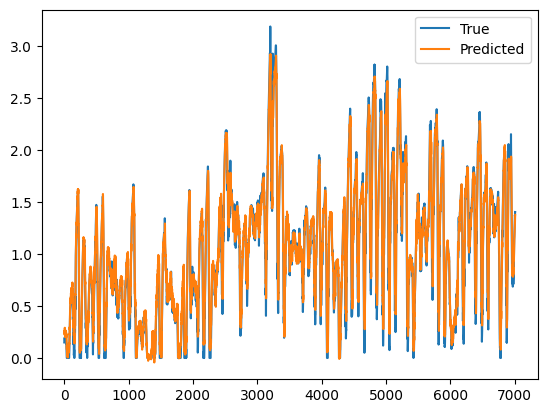

In [121]:
# Plot predictions
plt.plot(test_labels.cpu().numpy(), label='True')
plt.plot(np.concatenate(predictions), label='Predicted')
plt.legend()
plt.show()

In [67]:
i = 0
for param in lr_model.parameters():
    for weight in param:
        print(weight)
        i += 1
print(i)

tensor([ 0.1098,  0.0425, -0.0403,  0.0005, -0.0060,  0.0024,  0.0110,  0.0122,
        -0.0496,  0.0200, -0.0228,  0.0239, -0.0458, -0.0344, -0.0168,  0.0282,
         0.0516,  0.0053,  0.0139, -0.0837,  0.0513, -0.0164,  0.0405,  0.0023,
         0.0203, -0.0005, -0.0516,  0.0575, -0.0347,  0.0615, -0.0500,  0.2159,
        -0.1030, -0.0091, -0.0255,  0.0046, -0.0119, -0.0497, -0.0092,  0.0568,
        -0.0617,  0.0136, -0.0774,  0.0669, -0.0426, -0.0592,  0.0622,  0.0456,
        -0.0374, -0.0492,  0.0576, -0.0090, -0.0231, -0.0203,  0.0489, -0.0750,
         0.0440,  0.0499, -0.0027, -0.0120, -0.0539, -0.0284,  0.1981, -0.0380,
         0.0011,  0.0349,  0.0221, -0.0283,  0.0026,  0.0018, -0.0131,  0.0233,
        -0.0141,  0.0107, -0.0177,  0.0405,  0.0187,  0.0431,  0.0093,  0.0555,
        -0.0537,  0.0161,  0.0348,  0.0019, -0.0497,  0.0591,  0.0619,  0.0097,
         0.0450, -0.0251,  0.0243,  0.0449, -0.0524,  0.1642,  0.0340,  0.0269,
         0.0189, -0.0322,  0.0355, -0.02